In [1]:
import sim
import numpy as np
import sympy as sp
import pandas as pd
import time
import threading as thr


def connect(port):
# Establece la conexión a CoppeliaSim
# port debe coincidir con el puerto de conexión en VREP
# retorna el número de cliente o -1 si no puede establecer conexión
    sim.simxFinish(-1) # just in case, close all opened connections
    clientID=sim.simxStart('127.0.0.1',port,True,True,2000,5) # Conectarse
    if clientID == 0: print("conectado a", port)
    else: print("no se pudo conectar")
    return clientID

# Conectarse al servidor de VREP
# *** ejecutar cada vez que se reinicia la simulación ***
clientID = connect(19999)

retCode,Dummy=sim.simxGetObjectHandle(clientID,'Dummy',sim.simx_opmode_blocking)
retCode,joint1=sim.simxGetObjectHandle(clientID,'joint1',sim.simx_opmode_blocking)
retCode,joint2=sim.simxGetObjectHandle(clientID,'joint2',sim.simx_opmode_blocking)

retCode,muslo1=sim.simxGetObjectHandle(clientID,'muslo1',sim.simx_opmode_blocking)
retCode,rodilla1=sim.simxGetObjectHandle(clientID,'rodilla1',sim.simx_opmode_blocking)

retCode,muslo2=sim.simxGetObjectHandle(clientID,'muslo2',sim.simx_opmode_blocking)
retCode,rodilla2=sim.simxGetObjectHandle(clientID,'rodilla2',sim.simx_opmode_blocking)

retCode,muslo3=sim.simxGetObjectHandle(clientID,'muslo3',sim.simx_opmode_blocking)
retCode,rodilla3=sim.simxGetObjectHandle(clientID,'rodilla3',sim.simx_opmode_blocking)

retCode,muslo4=sim.simxGetObjectHandle(clientID,'muslo4',sim.simx_opmode_blocking)
retCode,rodilla4=sim.simxGetObjectHandle(clientID,'rodilla4',sim.simx_opmode_blocking)

Run = True

conectado a 19999


In [2]:
#import numpy as np
#import matplotlib.pyplot as plt
#import sympy as sp
#import pandas as pd

#-------------------------------------------------------------------------
#
#                       Funciones de la trayectoria
#
#-------------------------------------------------------------------------

def symTfromDH(theta, d, a, alpha):
    # theta y alpha en radianes
    # d y a en metros
    Rz = sp.Matrix([[sp.cos(theta), -sp.sin(theta), 0, 0],
                   [sp.sin(theta), sp.cos(theta), 0, 0],
                   [0, 0, 1, 0],
                   [0, 0, 0, 1]])
    tz = sp.Matrix([[1, 0, 0, 0],
                   [0, 1, 0, 0],
                   [0, 0, 1, d],
                   [0, 0, 0, 1]])
    ta = sp.Matrix([[1, 0, 0, a],
                   [0, 1, 0, 0],
                   [0, 0, 1, 0],
                   [0, 0, 0, 1]])
    Rx = sp.Matrix([[1, 0, 0, 0],
                   [0, sp.cos(alpha), -sp.sin(alpha), 0],
                   [0, sp.sin(alpha), sp.cos(alpha), 0],
                   [0, 0, 0, 1]])
    T = Rz*tz*ta*Rx
    return T



def find_intersection_points(center, radius, line_slope, line_intercept):
    a = 1 + line_slope**2
    b = -2 * center[0] + 2 * line_slope * (line_intercept - center[1])
    c = center[0]**2 + (line_intercept - center[1])**2 - radius**2

    discriminant = b**2 - 4*a*c

    if discriminant < 0:
        return []  # No intersection points

    x1 = (-b + np.sqrt(discriminant)) / (2*a)
    x2 = (-b - np.sqrt(discriminant)) / (2*a)
    y1 = line_slope * x1 + line_intercept
    y2 = line_slope * x2 + line_intercept

    return [(x1, y1), (x2, y2)]

def create_oval_through_points(point1, point2, altura, frames):
    x1, y1 = point1
    x2, y2 = point2
    
    # Calcular el ancho y la altura utilizando los puntos dados
    if x1 > x2:
        width = x1*2
    elif x1 < x2:
        width = x2*2
    height = altura/2
    
    # Calcular el centro del óvalo
    center_x = (x1 + x2) / 2
    center_y = (y1 + y2) / 2
    
    # Generar el óvalo utilizando las dimensiones calculadas
    theta = np.linspace(0, 2 * np.pi, frames)
    x = center_x + width/2 * np.cos(theta)
    y = center_y + height/2 * np.sin(theta)
    
    return x, y

def Get_Value(mov_x,mov_y,largo_extremidad):
    #largo_extremidad = 0.2
    q1 = sp.symbols('q1')
    q2 = sp.symbols('q2')

    T = sp.simplify(symTfromDH(q1, 0, largo_extremidad, 0)* symTfromDH(q2, 0, largo_extremidad, 0))
    
    df = pd.DataFrame(columns=['Muslo', 'Rodilla'])
    
    if len(mov_x) != len(mov_y):
        return print("Dimensiones de mov_x y mov_y no coinsiden",len(mov_x) ,len(mov_y))
    
    for i in range(len(mov_y)):
        a=mov_y[i]
        b=mov_x[i]
        # definimos las ecuaciones a resolver
        ec1, ec2 = T[3]-a, T[7]-b
        (ec1, ec2)
        # ahora resolvemos la ecuación utilizando nsolve()
        try:
            q = sp.nsolve((ec1, ec2),(q1,q2),(1,-1), prec=6)
            df.loc[len(df)] = {'Muslo': q[0], 'Rodilla': q[1]}
        except:
            print(a,b)
            print("no se pudo calcular")
            q = [0, 0, 0]
            
    filtro_1 = df['Muslo'] <= -3.5 # Borrar
    filtro_2 = df['Muslo'] >= 3.5 # Borrar

    df2 = df.drop(df[filtro_1].index)
    df2 = df2.drop(df[filtro_2].index)
    
    filtro_3 = df2['Rodilla'] <= -3 # Borrar
    
    df2 = df2.drop(df2[filtro_3].index)
    
    # Limpieza del primer y último dato para evitar comportamiento extraño
    df2 = df2.drop([0, len(df2)-1])
    
    return df2


#-------------------------------------------------------------------------
#
#                       Parametrización
#
#------------------------------------------------------------------------

# Descripción de Denavit-Hartenberg (a = largo de la extremidad (en metros))
#      theta     |      d      |      a      |    alpha
# ----------------------------------------------------------
#       q1             0             0.2            0
#       q2             0             0.2            0

def Get_Mov(largo_extremidad, altura_actual, Frames):
    # Parámetros de la circunferencia y la recta
    center = (0, 0)
    radius = largo_extremidad * 2
    line_slope = 0
    #altura_actual = 0.3

    # Encontrar puntos de intersección
    intersection_points = find_intersection_points(center, radius, line_slope, altura_actual)

    # Puntos que definen el óvalo
    point1 = intersection_points[0]
    point2 = intersection_points[1]

    # Crear el óvalo que pasa por los puntos dados
    #                                               , altura)
    x, y = create_oval_through_points(point1, point2, altura_actual, Frames)

    mov_x = []
    mov_y = []
    for i in range(len(y)):
        if y[i] <= altura_actual: # Si es menor que la distancia del robot al piso se puede elevar la pata
            mov_x.append(x[i])
            mov_y.append(y[i])

    #--------------------------------------------------------
    #
    #       aGREGAR EL ARRASTE, LA LINEA RECTA
    #
    #--------------------------------------------------------

    
    mitad = len(mov_y) // 2
    aux1 = [altura_actual for i in range(len(mov_y))]
    mov_y = aux1[mitad:] + mov_y + aux1[:mitad]
    aux1 = np.linspace(mov_x[len(mov_x)-1], mov_x[1], len(mov_x))
    aux2 = aux1[:mitad]
    aux3 = aux1[mitad:]
    mov_x = np.concatenate((aux3,mov_x))
    mov_x = np.concatenate((mov_x,aux2))

    return Get_Value(mov_x,mov_y,largo_extremidad)

def Pierna_Delantera_Izquierda(df, velocidad):
    while Run:
        for index, row in df.iterrows():
            retCode = sim.simxSetJointTargetPosition(clientID, muslo1, row['Muslo'], sim.simx_opmode_oneshot)
            retCode = sim.simxSetJointTargetPosition(clientID, rodilla1, row['Rodilla'], sim.simx_opmode_oneshot)
            time.sleep(velocidad) #delay entre cada movimiento ejemplo: 0.001

def Pierna_Delantera_Derecha(df, velocidad):
    while Run:
        for index, row in df.iterrows():
            retCode = sim.simxSetJointTargetPosition(clientID, muslo4, row['Muslo'], sim.simx_opmode_oneshot)
            retCode = sim.simxSetJointTargetPosition(clientID, rodilla4, row['Rodilla'], sim.simx_opmode_oneshot)
            time.sleep(velocidad) #delay entre cada movimiento ejemplo: 0.001
    
def Pierna_Tracera_Izquierda(df, velocidad):
    while Run:
        for index, row in df.iterrows():
            retCode = sim.simxSetJointTargetPosition(clientID, muslo2, row['Muslo'], sim.simx_opmode_oneshot)
            retCode = sim.simxSetJointTargetPosition(clientID, rodilla2, row['Rodilla'], sim.simx_opmode_oneshot)
            time.sleep(velocidad) #delay entre cada movimiento ejemplo: 0.001
        
def Pierna_Tracera_Derecha(df, velocidad):
    while Run:
        for index, row in df.iterrows():
            retCode = sim.simxSetJointTargetPosition(clientID, muslo3, row['Muslo'], sim.simx_opmode_oneshot)
            retCode = sim.simxSetJointTargetPosition(clientID, rodilla3, row['Rodilla'], sim.simx_opmode_oneshot)
            time.sleep(velocidad) #delay entre cada movimiento ejemplo: 0.001

def esperar_input(s):
    #input("Presiona Enter para finalizar los hilos...")
    time.sleep(s) 
    global Run
    Run = False
    # Detener los hilos
    
def MovimientoTotal(orden, delay_mov, delay_hilo,time_stop):
    global Run
    Run = True
    funciones = [Pierna_Delantera_Izquierda, Pierna_Tracera_Izquierda, Pierna_Delantera_Derecha, Pierna_Tracera_Derecha]
    hilos = []
    for i in range(4):
        hilo = thr.Thread(target=funciones[i], args=(orden,delay_mov))
        hilos.append(hilo)

    hilo_1 = thr.Thread(target=esperar_input, args=(time_stop,))
    hilo_1.start()
    # Iniciar los hilos
    for hilo in hilos:
        hilo.start()
        time.sleep(delay_hilo)

    hilo_1.join()

        # Esperar a que los hilos terminen
    for hilo in hilos:
        hilo.join()

In [3]:

# Verificar el Run = True
# Get_Mov (largo de cada extremidad , distancia del torso al suelo, frames para los movimientos)
retroceso = Get_Mov(0.2,0.3,400) # levanta y arrastra
avance = retroceso[::-1] # arrastra y levanta

# Movimiento Vertical
mov_x2 = [0.0 for i in range(100)]
mov_y2 = np.linspace(0.1, 0.4, 100)

mov_to_down = Get_Value(mov_x2,mov_y2,0.2) # Descenso
mov_to_up = mov_to_down[::-1]

0.3 -0.24604695789252318
no se pudo calcular


In [4]:
# (orden, delay_mov, delay_hilo,time_stop)
MovimientoTotal(retroceso, 0.001, 0.25, 10)

<function matplotlib.pyplot.show(close=None, block=None)>

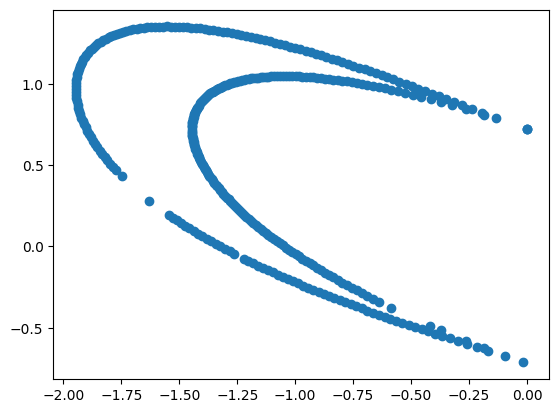

In [6]:
import matplotlib.pyplot as plt

plt.scatter(x=avance['Rodilla'], y=avance['Muslo'])
plt.show